# Neural Networks for MNIST dataset

In [17]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset
import numpy as np
from tqdm import tqdm
import pandas as pd

In [2]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Loading MNIST
Here we load the dataset and create data loaders.

In [3]:
train_ds = datasets.MNIST('data', train=True, download=True, 
                       transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
test_ds = datasets.MNIST('data', train=False, download=True, 
                       transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [4]:
batch_size = 32
#batch_size = 5 # for testing
kwargs = {'num_workers': 1, 'pin_memory': True} 

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=False, **kwargs)

## Looking at Examples

In [5]:
train_dl = iter(train_loader)
x, y = next(train_dl)

In [6]:
print(x.shape, y.shape)

torch.Size([32, 1, 28, 28]) torch.Size([32])


Looking are images

In [7]:
def show(img, title=None):
    plt.imshow(img, interpolation='none', cmap="gray")
    if title is not None: plt.title(title)

In [8]:
# first from torch to numpy
X = x.numpy(); Y = y.numpy()
X.shape

(32, 1, 28, 28)

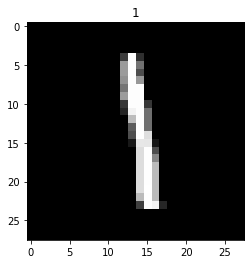

In [9]:
show(X[0][0], Y[0])

In [10]:
print(X[0][0][:4][:4])

[[-0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296]
 [-0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296]
 [-0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421

## Feed Forward Neural Network

In [33]:
# for the number of neurons in the hidden unit
def get_model(M = 300):
    net = nn.Sequential(nn.Linear(28*28, M),
                        nn.ReLU(),
                        nn.Linear(M, 10))
    return net #.cuda()

In [34]:
def train_model(train_loader, test_loader, num_epochs, model, optimizer):
    #model.train()
    for epoch in range(num_epochs):
        model.train()
        sum_loss = 0.0
        total = 0
        for i, (images, labels) in enumerate(train_loader):  
            batch = images.shape[0] # size of the batch
            # Convert torch tensor to Variable, change shape of the input
            images = images.view(-1, 28*28) #.cuda()
        
            # Forward + Backward + Optimize
            optimizer.zero_grad()  # zero the gradient buffer
            outputs = model(images)
            loss = F.cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()
        
            total += batch
            sum_loss += batch * loss.item()
                
        train_loss = sum_loss/total
        print('Epoch [%d/%d], Loss: %.4f' %(epoch+1, num_epochs, train_loss))
        val_acc, val_loss = model_accuracy_loss(model, test_loader)
        print('Epoch [%d/%d], Valid Accuracy: %.4f, Valid Loss: %.4f' %(epoch+1, num_epochs, val_acc, val_loss))
    return val_acc, val_loss, train_loss

In [35]:
def model_accuracy_loss(model, test_loader):
    model.eval()
    correct = 0
    sum_loss = 0.0
    total = 0
    for images, labels in test_loader:
        images = images.view(-1, 28*28)  #.cuda()
        outputs = model(images)
        _, pred = torch.max(outputs.data, 1)
        loss = F.cross_entropy(outputs, labels)
        sum_loss += labels.size(0)*loss.item()
        total += labels.size(0)
        correct += pred.eq(labels.data).sum().item()
    return 100 * correct / total, sum_loss/ total

In [36]:
net = get_model()
learning_rate = 0.01
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
model_accuracy_loss(net, test_loader)

(10.75, 2.338864084625244)

In [37]:
val_acc, val_loss, train_loss = train_model(train_loader, test_loader, num_epochs=2, model=net, optimizer=optimizer)

Epoch [1/2], Loss: 0.3492
Epoch [1/2], Valid Accuracy: 91.5300, Valid Loss: 0.3213
Epoch [2/2], Loss: 0.2775
Epoch [2/2], Valid Accuracy: 92.4200, Valid Loss: 0.2762


---
# Q1

In [38]:
def find_bt_lr():
    lr = [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]
    val_accrarcy =[]
    for l in tqdm(lr):
        print('='*50)
        net = get_model()
        optimizer = optim.Adam(net.parameters(), lr=l)
        val_acc, val_loss, train_loss = train_model(train_loader, test_loader, num_epochs=10, model=net, optimizer=optimizer)
        val_accrarcy.append(val_acc)
        print('='*50)
    dic = {'lr':lr,'val_accrarcy':val_accrarcy}
    return pd.DataFrame.from_dict(dic)

In [39]:
q1df = find_bt_lr()
q1df

  0%|                                      | 0/6 [00:00<?, ?it/s]

Epoch [1/10], Loss: 66.9753
Epoch [1/10], Valid Accuracy: 11.3800, Valid Loss: 2.6099
Epoch [2/10], Loss: 2.8933
Epoch [2/10], Valid Accuracy: 10.6700, Valid Loss: 2.3852
Epoch [3/10], Loss: 2.8546
Epoch [3/10], Valid Accuracy: 11.3800, Valid Loss: 2.4327
Epoch [4/10], Loss: 2.4128
Epoch [4/10], Valid Accuracy: 10.1200, Valid Loss: 2.4191
Epoch [5/10], Loss: 2.4074
Epoch [5/10], Valid Accuracy: 9.8400, Valid Loss: 2.3470
Epoch [6/10], Loss: 2.4051
Epoch [6/10], Valid Accuracy: 10.3100, Valid Loss: 2.4461
Epoch [7/10], Loss: 2.4115
Epoch [7/10], Valid Accuracy: 9.8400, Valid Loss: 2.3456
Epoch [8/10], Loss: 2.4066
Epoch [8/10], Valid Accuracy: 8.9500, Valid Loss: 2.4370
Epoch [9/10], Loss: 2.4066
Epoch [9/10], Valid Accuracy: 8.9500, Valid Loss: 2.5756
Epoch [10/10], Loss: 2.4077


 17%|█████                         | 1/6 [01:09<05:49, 69.93s/it]

Epoch [10/10], Valid Accuracy: 10.3100, Valid Loss: 2.3882
Epoch [1/10], Loss: 2.6296
Epoch [1/10], Valid Accuracy: 9.8600, Valid Loss: 2.3080
Epoch [2/10], Loss: 2.3282
Epoch [2/10], Valid Accuracy: 9.7500, Valid Loss: 2.3289
Epoch [3/10], Loss: 2.3167
Epoch [3/10], Valid Accuracy: 11.3600, Valid Loss: 2.3120
Epoch [4/10], Loss: 2.3138
Epoch [4/10], Valid Accuracy: 8.9300, Valid Loss: 2.3191
Epoch [5/10], Loss: 2.3139
Epoch [5/10], Valid Accuracy: 10.1000, Valid Loss: 2.3098
Epoch [6/10], Loss: 2.3141
Epoch [6/10], Valid Accuracy: 9.7500, Valid Loss: 2.3159
Epoch [7/10], Loss: 2.3142
Epoch [7/10], Valid Accuracy: 9.8300, Valid Loss: 2.3102
Epoch [8/10], Loss: 2.3127
Epoch [8/10], Valid Accuracy: 10.1100, Valid Loss: 2.3105
Epoch [9/10], Loss: 2.3144
Epoch [9/10], Valid Accuracy: 9.8300, Valid Loss: 2.3103
Epoch [10/10], Loss: 2.3145


 33%|██████████                    | 2/6 [02:20<04:40, 70.18s/it]

Epoch [10/10], Valid Accuracy: 11.3600, Valid Loss: 2.3115
Epoch [1/10], Loss: 0.3427
Epoch [1/10], Valid Accuracy: 92.0500, Valid Loss: 0.2907
Epoch [2/10], Loss: 0.2597
Epoch [2/10], Valid Accuracy: 93.6700, Valid Loss: 0.2590
Epoch [3/10], Loss: 0.2418
Epoch [3/10], Valid Accuracy: 91.4800, Valid Loss: 0.3078
Epoch [4/10], Loss: 0.2446
Epoch [4/10], Valid Accuracy: 92.8900, Valid Loss: 0.3385
Epoch [5/10], Loss: 0.2331
Epoch [5/10], Valid Accuracy: 93.8100, Valid Loss: 0.2977
Epoch [6/10], Loss: 0.2313
Epoch [6/10], Valid Accuracy: 93.8200, Valid Loss: 0.2795
Epoch [7/10], Loss: 0.2144
Epoch [7/10], Valid Accuracy: 93.4900, Valid Loss: 0.3194
Epoch [8/10], Loss: 0.2170
Epoch [8/10], Valid Accuracy: 94.0000, Valid Loss: 0.3087
Epoch [9/10], Loss: 0.2179
Epoch [9/10], Valid Accuracy: 94.2000, Valid Loss: 0.3093
Epoch [10/10], Loss: 0.2138


 50%|███████████████               | 3/6 [03:30<03:30, 70.31s/it]

Epoch [10/10], Valid Accuracy: 93.8500, Valid Loss: 0.3209
Epoch [1/10], Loss: 0.2020
Epoch [1/10], Valid Accuracy: 95.2700, Valid Loss: 0.1463
Epoch [2/10], Loss: 0.0882
Epoch [2/10], Valid Accuracy: 97.0900, Valid Loss: 0.0899
Epoch [3/10], Loss: 0.0646
Epoch [3/10], Valid Accuracy: 97.1100, Valid Loss: 0.0977
Epoch [4/10], Loss: 0.0489
Epoch [4/10], Valid Accuracy: 97.1400, Valid Loss: 0.0978
Epoch [5/10], Loss: 0.0387
Epoch [5/10], Valid Accuracy: 97.3200, Valid Loss: 0.0943
Epoch [6/10], Loss: 0.0338
Epoch [6/10], Valid Accuracy: 97.8000, Valid Loss: 0.0902
Epoch [7/10], Loss: 0.0284
Epoch [7/10], Valid Accuracy: 97.9900, Valid Loss: 0.0814
Epoch [8/10], Loss: 0.0252
Epoch [8/10], Valid Accuracy: 97.9700, Valid Loss: 0.0971
Epoch [9/10], Loss: 0.0226
Epoch [9/10], Valid Accuracy: 97.7700, Valid Loss: 0.0968
Epoch [10/10], Loss: 0.0219


 67%|████████████████████          | 4/6 [04:41<02:21, 70.52s/it]

Epoch [10/10], Valid Accuracy: 97.4800, Valid Loss: 0.1305
Epoch [1/10], Loss: 0.4047
Epoch [1/10], Valid Accuracy: 93.4200, Valid Loss: 0.2282
Epoch [2/10], Loss: 0.1982
Epoch [2/10], Valid Accuracy: 95.1400, Valid Loss: 0.1696
Epoch [3/10], Loss: 0.1451
Epoch [3/10], Valid Accuracy: 96.3300, Valid Loss: 0.1297
Epoch [4/10], Loss: 0.1135
Epoch [4/10], Valid Accuracy: 96.9500, Valid Loss: 0.1071
Epoch [5/10], Loss: 0.0917
Epoch [5/10], Valid Accuracy: 97.1400, Valid Loss: 0.0957
Epoch [6/10], Loss: 0.0763
Epoch [6/10], Valid Accuracy: 97.4900, Valid Loss: 0.0856
Epoch [7/10], Loss: 0.0643
Epoch [7/10], Valid Accuracy: 97.5800, Valid Loss: 0.0782
Epoch [8/10], Loss: 0.0548
Epoch [8/10], Valid Accuracy: 97.6200, Valid Loss: 0.0794
Epoch [9/10], Loss: 0.0471
Epoch [9/10], Valid Accuracy: 97.7900, Valid Loss: 0.0728
Epoch [10/10], Loss: 0.0403


 83%|█████████████████████████     | 5/6 [05:54<01:11, 71.41s/it]

Epoch [10/10], Valid Accuracy: 97.9700, Valid Loss: 0.0655
Epoch [1/10], Loss: 1.1255
Epoch [1/10], Valid Accuracy: 87.4900, Valid Loss: 0.5720
Epoch [2/10], Loss: 0.4781
Epoch [2/10], Valid Accuracy: 90.0500, Valid Loss: 0.3915
Epoch [3/10], Loss: 0.3728
Epoch [3/10], Valid Accuracy: 91.0900, Valid Loss: 0.3326
Epoch [4/10], Loss: 0.3275
Epoch [4/10], Valid Accuracy: 91.5900, Valid Loss: 0.3005
Epoch [5/10], Loss: 0.2998
Epoch [5/10], Valid Accuracy: 92.1900, Valid Loss: 0.2787
Epoch [6/10], Loss: 0.2794
Epoch [6/10], Valid Accuracy: 92.5500, Valid Loss: 0.2621
Epoch [7/10], Loss: 0.2630
Epoch [7/10], Valid Accuracy: 92.8100, Valid Loss: 0.2498
Epoch [8/10], Loss: 0.2491
Epoch [8/10], Valid Accuracy: 93.1500, Valid Loss: 0.2376
Epoch [9/10], Loss: 0.2366
Epoch [9/10], Valid Accuracy: 93.4200, Valid Loss: 0.2267
Epoch [10/10], Loss: 0.2256


100%|██████████████████████████████| 6/6 [07:05<00:00, 70.89s/it]

Epoch [10/10], Valid Accuracy: 93.7900, Valid Loss: 0.2177


,lr,val_accrarcy
0,1.00000,10.31
1,0.10000,11.36
2,0.01000,93.85
3,0.00100,97.48
4,0.00010,97.97
5,0.00001,93.79


> From above table we can see the two best learning rates are 0.001 and 0.0001.

---

# Q2

In [42]:
def find_bt_hl():
    hidden_layer = [10, 50, 100, 300, 1000, 2000]
    val_accrarcy =[]
    for h in tqdm(hidden_layer):
        print('='*50)
        net = get_model(M = h)
        optimizer = optim.Adam(net.parameters(), lr=0.01)
        val_acc, val_loss, train_loss = train_model(train_loader, test_loader, num_epochs=10, model=net, optimizer=optimizer)
        val_accrarcy.append(val_acc)
        print('='*50)
    dic = {'hidden_layer':hidden_layer,'val_accrarcy':val_accrarcy}
    return pd.DataFrame.from_dict(dic)

In [43]:
q2df = find_bt_hl()

  0%|                                      | 0/6 [00:00<?, ?it/s]

Epoch [1/10], Loss: 0.5020
Epoch [1/10], Valid Accuracy: 83.7100, Valid Loss: 0.5345
Epoch [2/10], Loss: 0.4400
Epoch [2/10], Valid Accuracy: 86.5800, Valid Loss: 0.4483
Epoch [3/10], Loss: 0.4321
Epoch [3/10], Valid Accuracy: 89.5100, Valid Loss: 0.3873
Epoch [4/10], Loss: 0.4286
Epoch [4/10], Valid Accuracy: 86.0600, Valid Loss: 0.4828
Epoch [5/10], Loss: 0.4229
Epoch [5/10], Valid Accuracy: 89.0400, Valid Loss: 0.3993
Epoch [6/10], Loss: 0.4194
Epoch [6/10], Valid Accuracy: 88.6800, Valid Loss: 0.4087
Epoch [7/10], Loss: 0.4184
Epoch [7/10], Valid Accuracy: 87.3800, Valid Loss: 0.4365
Epoch [8/10], Loss: 0.4152
Epoch [8/10], Valid Accuracy: 88.2200, Valid Loss: 0.4152
Epoch [9/10], Loss: 0.4154
Epoch [9/10], Valid Accuracy: 85.7200, Valid Loss: 0.4974
Epoch [10/10], Loss: 0.4076


 17%|█████                         | 1/6 [01:07<05:35, 67.06s/it]

Epoch [10/10], Valid Accuracy: 87.3700, Valid Loss: 0.4612
Epoch [1/10], Loss: 0.3322
Epoch [1/10], Valid Accuracy: 92.4300, Valid Loss: 0.2815
Epoch [2/10], Loss: 0.2697
Epoch [2/10], Valid Accuracy: 93.3100, Valid Loss: 0.2520
Epoch [3/10], Loss: 0.2615
Epoch [3/10], Valid Accuracy: 92.4800, Valid Loss: 0.3069
Epoch [4/10], Loss: 0.2534
Epoch [4/10], Valid Accuracy: 92.8600, Valid Loss: 0.3222
Epoch [5/10], Loss: 0.2469
Epoch [5/10], Valid Accuracy: 92.8100, Valid Loss: 0.3034
Epoch [6/10], Loss: 0.2457
Epoch [6/10], Valid Accuracy: 92.9800, Valid Loss: 0.3069
Epoch [7/10], Loss: 0.2451
Epoch [7/10], Valid Accuracy: 92.0900, Valid Loss: 0.3249
Epoch [8/10], Loss: 0.2469
Epoch [8/10], Valid Accuracy: 93.4600, Valid Loss: 0.3026
Epoch [9/10], Loss: 0.2458
Epoch [9/10], Valid Accuracy: 93.0200, Valid Loss: 0.3348
Epoch [10/10], Loss: 0.2366


 33%|██████████                    | 2/6 [02:14<04:28, 67.06s/it]

Epoch [10/10], Valid Accuracy: 93.6300, Valid Loss: 0.3145
Epoch [1/10], Loss: 0.3301
Epoch [1/10], Valid Accuracy: 92.8400, Valid Loss: 0.2743
Epoch [2/10], Loss: 0.2621
Epoch [2/10], Valid Accuracy: 94.5100, Valid Loss: 0.2451
Epoch [3/10], Loss: 0.2561
Epoch [3/10], Valid Accuracy: 91.8800, Valid Loss: 0.3378
Epoch [4/10], Loss: 0.2417
Epoch [4/10], Valid Accuracy: 93.5400, Valid Loss: 0.2619
Epoch [5/10], Loss: 0.2377
Epoch [5/10], Valid Accuracy: 94.4000, Valid Loss: 0.2520
Epoch [6/10], Loss: 0.2336
Epoch [6/10], Valid Accuracy: 94.5600, Valid Loss: 0.2490
Epoch [7/10], Loss: 0.2220
Epoch [7/10], Valid Accuracy: 93.7500, Valid Loss: 0.2965
Epoch [8/10], Loss: 0.2206
Epoch [8/10], Valid Accuracy: 94.4700, Valid Loss: 0.2778
Epoch [9/10], Loss: 0.2208
Epoch [9/10], Valid Accuracy: 94.3800, Valid Loss: 0.3112
Epoch [10/10], Loss: 0.2149


 50%|███████████████               | 3/6 [03:21<03:21, 67.33s/it]

Epoch [10/10], Valid Accuracy: 93.8800, Valid Loss: 0.3147
Epoch [1/10], Loss: 0.3447
Epoch [1/10], Valid Accuracy: 94.5000, Valid Loss: 0.2184
Epoch [2/10], Loss: 0.2685
Epoch [2/10], Valid Accuracy: 93.1500, Valid Loss: 0.2692
Epoch [3/10], Loss: 0.2533
Epoch [3/10], Valid Accuracy: 93.6500, Valid Loss: 0.2883
Epoch [4/10], Loss: 0.2420
Epoch [4/10], Valid Accuracy: 93.0300, Valid Loss: 0.2693
Epoch [5/10], Loss: 0.2316
Epoch [5/10], Valid Accuracy: 93.2800, Valid Loss: 0.3281
Epoch [6/10], Loss: 0.2314
Epoch [6/10], Valid Accuracy: 94.3300, Valid Loss: 0.2824
Epoch [7/10], Loss: 0.2283
Epoch [7/10], Valid Accuracy: 94.4200, Valid Loss: 0.2597
Epoch [8/10], Loss: 0.2271
Epoch [8/10], Valid Accuracy: 94.1000, Valid Loss: 0.2720
Epoch [9/10], Loss: 0.2151
Epoch [9/10], Valid Accuracy: 93.7200, Valid Loss: 0.3687
Epoch [10/10], Loss: 0.2132


 67%|████████████████████          | 4/6 [04:31<02:16, 68.25s/it]

Epoch [10/10], Valid Accuracy: 94.4800, Valid Loss: 0.2847
Epoch [1/10], Loss: 0.3772
Epoch [1/10], Valid Accuracy: 92.6600, Valid Loss: 0.2954
Epoch [2/10], Loss: 0.2740
Epoch [2/10], Valid Accuracy: 92.5200, Valid Loss: 0.4476
Epoch [3/10], Loss: 0.2639
Epoch [3/10], Valid Accuracy: 92.6500, Valid Loss: 0.3110
Epoch [4/10], Loss: 0.2447
Epoch [4/10], Valid Accuracy: 94.2500, Valid Loss: 0.2718
Epoch [5/10], Loss: 0.2376
Epoch [5/10], Valid Accuracy: 94.2000, Valid Loss: 0.2733
Epoch [6/10], Loss: 0.2413
Epoch [6/10], Valid Accuracy: 94.6400, Valid Loss: 0.2861
Epoch [7/10], Loss: 0.2213
Epoch [7/10], Valid Accuracy: 94.2000, Valid Loss: 0.3287
Epoch [8/10], Loss: 0.2413
Epoch [8/10], Valid Accuracy: 94.0300, Valid Loss: 0.3107
Epoch [9/10], Loss: 0.2239
Epoch [9/10], Valid Accuracy: 93.7600, Valid Loss: 0.3442
Epoch [10/10], Loss: 0.2153


 83%|█████████████████████████     | 5/6 [06:40<01:30, 90.14s/it]

Epoch [10/10], Valid Accuracy: 93.4800, Valid Loss: 0.3741
Epoch [1/10], Loss: 0.4082
Epoch [1/10], Valid Accuracy: 92.8700, Valid Loss: 0.2801
Epoch [2/10], Loss: 0.2838
Epoch [2/10], Valid Accuracy: 91.6800, Valid Loss: 0.3449
Epoch [3/10], Loss: 0.2641
Epoch [3/10], Valid Accuracy: 93.3100, Valid Loss: 0.3077
Epoch [4/10], Loss: 0.2436
Epoch [4/10], Valid Accuracy: 93.3400, Valid Loss: 0.3072
Epoch [5/10], Loss: 0.2445
Epoch [5/10], Valid Accuracy: 93.9000, Valid Loss: 0.2866
Epoch [6/10], Loss: 0.2402
Epoch [6/10], Valid Accuracy: 91.8800, Valid Loss: 0.3910
Epoch [7/10], Loss: 0.2378
Epoch [7/10], Valid Accuracy: 93.6000, Valid Loss: 0.3214
Epoch [8/10], Loss: 0.2302
Epoch [8/10], Valid Accuracy: 93.6500, Valid Loss: 0.3131
Epoch [9/10], Loss: 0.2155
Epoch [9/10], Valid Accuracy: 92.9900, Valid Loss: 0.3374
Epoch [10/10], Loss: 0.2169


100%|█████████████████████████████| 6/6 [10:25<00:00, 104.20s/it]

Epoch [10/10], Valid Accuracy: 93.9500, Valid Loss: 0.3212


In [44]:
q2df

,hidden_layer,val_accrarcy
0,10,87.37
1,50,93.63
2,100,93.88
3,300,94.48
4,1000,93.48
5,2000,93.95


> Intuitively, the larger the hiddent layer, the lower the loss and higher the accuracy, however, the higher the chance the model will over fit. If we were just looking at the last Valid Accuracy, `hidden_layer` with 300 achieves the best final validation accuracy. When we study the in progress statistics carefully, we can see that some of the models (ex. model with hidden layer [1000,2000]) start to over fit on the training set. Their traing loss continuously decreasing in each epoch while their validation losss strated to pop back up and validation accuracy started to decrease. This parabola shape is a clear sign of overfitting
---

## Models with L2 regularization
To add L2 regularization use the `weight_decay` argument on the optimizer

In [23]:
# optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay = 0.01)

In [45]:
def find_bt_wd():
    weight_decay = [0, 0.0001, 0.001, 0.01, 0.1, 0.3]
    trainloss = []
    validation_loss = []
    val_accrarcy =[]
    
    for w in tqdm(weight_decay):
        print('='*50)
        net = get_model(M = 300)
        optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay = w)
        val_acc, val_loss, train_loss = train_model(train_loader, test_loader, num_epochs=20, model=net, optimizer=optimizer)
        
        trainloss.append(train_loss)
        validation_loss.append(val_loss)
        val_accrarcy.append(val_acc)
        
        print('='*50)
    dic = {'weight_decay':weight_decay,
           'train_loss':trainloss,
           'validation_loss':validation_loss,
           'val_accrarcy':val_accrarcy}
    return pd.DataFrame.from_dict(dic)

In [46]:
q3df = find_bt_wd()

  0%|                                      | 0/6 [00:00<?, ?it/s]

Epoch [1/20], Loss: 0.2000
Epoch [1/20], Valid Accuracy: 97.0400, Valid Loss: 0.0947
Epoch [2/20], Loss: 0.0859
Epoch [2/20], Valid Accuracy: 97.5000, Valid Loss: 0.0832
Epoch [3/20], Loss: 0.0628
Epoch [3/20], Valid Accuracy: 97.5600, Valid Loss: 0.0794
Epoch [4/20], Loss: 0.0476
Epoch [4/20], Valid Accuracy: 97.8000, Valid Loss: 0.0757
Epoch [5/20], Loss: 0.0397
Epoch [5/20], Valid Accuracy: 97.4100, Valid Loss: 0.0943
Epoch [6/20], Loss: 0.0321
Epoch [6/20], Valid Accuracy: 97.9800, Valid Loss: 0.0830
Epoch [7/20], Loss: 0.0288
Epoch [7/20], Valid Accuracy: 97.2000, Valid Loss: 0.1206
Epoch [8/20], Loss: 0.0254
Epoch [8/20], Valid Accuracy: 97.8600, Valid Loss: 0.0872
Epoch [9/20], Loss: 0.0213
Epoch [9/20], Valid Accuracy: 97.7100, Valid Loss: 0.0981
Epoch [10/20], Loss: 0.0217
Epoch [10/20], Valid Accuracy: 97.6500, Valid Loss: 0.1217
Epoch [11/20], Loss: 0.0221
Epoch [11/20], Valid Accuracy: 97.9000, Valid Loss: 0.1066
Epoch [12/20], Loss: 0.0164
Epoch [12/20], Valid Accuracy: 97

 17%|████▊                        | 1/6 [02:20<11:42, 140.41s/it]

Epoch [20/20], Valid Accuracy: 97.9500, Valid Loss: 0.1400
Epoch [1/20], Loss: 0.2005
Epoch [1/20], Valid Accuracy: 96.9000, Valid Loss: 0.1031
Epoch [2/20], Loss: 0.0896
Epoch [2/20], Valid Accuracy: 97.2900, Valid Loss: 0.0889
Epoch [3/20], Loss: 0.0669
Epoch [3/20], Valid Accuracy: 97.6900, Valid Loss: 0.0749
Epoch [4/20], Loss: 0.0528
Epoch [4/20], Valid Accuracy: 97.2500, Valid Loss: 0.0985
Epoch [5/20], Loss: 0.0467
Epoch [5/20], Valid Accuracy: 97.3700, Valid Loss: 0.0885
Epoch [6/20], Loss: 0.0389
Epoch [6/20], Valid Accuracy: 97.8500, Valid Loss: 0.0778
Epoch [7/20], Loss: 0.0353
Epoch [7/20], Valid Accuracy: 97.9600, Valid Loss: 0.0709
Epoch [8/20], Loss: 0.0350
Epoch [8/20], Valid Accuracy: 97.3800, Valid Loss: 0.0899
Epoch [9/20], Loss: 0.0298
Epoch [9/20], Valid Accuracy: 98.0400, Valid Loss: 0.0792
Epoch [10/20], Loss: 0.0298
Epoch [10/20], Valid Accuracy: 97.8100, Valid Loss: 0.0852
Epoch [11/20], Loss: 0.0290
Epoch [11/20], Valid Accuracy: 97.1700, Valid Loss: 0.1076
Ep

 33%|█████████▋                   | 2/6 [04:42<09:25, 141.31s/it]

Epoch [20/20], Valid Accuracy: 97.9100, Valid Loss: 0.0879
Epoch [1/20], Loss: 0.2078
Epoch [1/20], Valid Accuracy: 96.6400, Valid Loss: 0.1109
Epoch [2/20], Loss: 0.1078
Epoch [2/20], Valid Accuracy: 96.3700, Valid Loss: 0.1114
Epoch [3/20], Loss: 0.0925
Epoch [3/20], Valid Accuracy: 97.0200, Valid Loss: 0.0942
Epoch [4/20], Loss: 0.0835
Epoch [4/20], Valid Accuracy: 97.2700, Valid Loss: 0.0891
Epoch [5/20], Loss: 0.0799
Epoch [5/20], Valid Accuracy: 97.5300, Valid Loss: 0.0839
Epoch [6/20], Loss: 0.0769
Epoch [6/20], Valid Accuracy: 96.6800, Valid Loss: 0.1066
Epoch [7/20], Loss: 0.0733
Epoch [7/20], Valid Accuracy: 97.1600, Valid Loss: 0.0913
Epoch [8/20], Loss: 0.0690
Epoch [8/20], Valid Accuracy: 97.5500, Valid Loss: 0.0801
Epoch [9/20], Loss: 0.0707
Epoch [9/20], Valid Accuracy: 97.3800, Valid Loss: 0.0857
Epoch [10/20], Loss: 0.0683
Epoch [10/20], Valid Accuracy: 97.4000, Valid Loss: 0.0809
Epoch [11/20], Loss: 0.0671
Epoch [11/20], Valid Accuracy: 97.4600, Valid Loss: 0.0813
Ep

 50%|██████████████▌              | 3/6 [07:02<07:02, 140.80s/it]

Epoch [20/20], Valid Accuracy: 97.3300, Valid Loss: 0.0819
Epoch [1/20], Loss: 0.2710
Epoch [1/20], Valid Accuracy: 94.6800, Valid Loss: 0.1884
Epoch [2/20], Loss: 0.2020
Epoch [2/20], Valid Accuracy: 95.2300, Valid Loss: 0.1729
Epoch [3/20], Loss: 0.1864
Epoch [3/20], Valid Accuracy: 95.0200, Valid Loss: 0.1733
Epoch [4/20], Loss: 0.1795
Epoch [4/20], Valid Accuracy: 94.9300, Valid Loss: 0.1734
Epoch [5/20], Loss: 0.1747
Epoch [5/20], Valid Accuracy: 95.6300, Valid Loss: 0.1551
Epoch [6/20], Loss: 0.1715
Epoch [6/20], Valid Accuracy: 95.9900, Valid Loss: 0.1564
Epoch [7/20], Loss: 0.1701
Epoch [7/20], Valid Accuracy: 95.6400, Valid Loss: 0.1514
Epoch [8/20], Loss: 0.1706
Epoch [8/20], Valid Accuracy: 95.7600, Valid Loss: 0.1552
Epoch [9/20], Loss: 0.1675
Epoch [9/20], Valid Accuracy: 95.7400, Valid Loss: 0.1579
Epoch [10/20], Loss: 0.1676
Epoch [10/20], Valid Accuracy: 95.4600, Valid Loss: 0.1553
Epoch [11/20], Loss: 0.1682
Epoch [11/20], Valid Accuracy: 95.7800, Valid Loss: 0.1547
Ep

 67%|███████████████████▎         | 4/6 [09:24<04:42, 141.09s/it]

Epoch [20/20], Valid Accuracy: 95.3400, Valid Loss: 0.1628
Epoch [1/20], Loss: 0.5365
Epoch [1/20], Valid Accuracy: 87.9500, Valid Loss: 0.4816
Epoch [2/20], Loss: 0.5007
Epoch [2/20], Valid Accuracy: 88.3100, Valid Loss: 0.4597
Epoch [3/20], Loss: 0.4883
Epoch [3/20], Valid Accuracy: 89.9500, Valid Loss: 0.4542
Epoch [4/20], Loss: 0.4792
Epoch [4/20], Valid Accuracy: 89.4000, Valid Loss: 0.4479
Epoch [5/20], Loss: 0.4766
Epoch [5/20], Valid Accuracy: 88.7200, Valid Loss: 0.4611
Epoch [6/20], Loss: 0.4724
Epoch [6/20], Valid Accuracy: 89.8600, Valid Loss: 0.4470
Epoch [7/20], Loss: 0.4713
Epoch [7/20], Valid Accuracy: 89.3700, Valid Loss: 0.4453
Epoch [8/20], Loss: 0.4704
Epoch [8/20], Valid Accuracy: 89.6600, Valid Loss: 0.4517
Epoch [9/20], Loss: 0.4694
Epoch [9/20], Valid Accuracy: 89.6700, Valid Loss: 0.4530
Epoch [10/20], Loss: 0.4683
Epoch [10/20], Valid Accuracy: 89.3300, Valid Loss: 0.4549
Epoch [11/20], Loss: 0.4686
Epoch [11/20], Valid Accuracy: 89.8500, Valid Loss: 0.4413
Ep

 83%|████████████████████████▏    | 5/6 [11:46<02:21, 141.40s/it]

Epoch [20/20], Valid Accuracy: 89.4000, Valid Loss: 0.4610
Epoch [1/20], Loss: 0.8730
Epoch [1/20], Valid Accuracy: 83.8800, Valid Loss: 0.8155
Epoch [2/20], Loss: 0.8429
Epoch [2/20], Valid Accuracy: 83.6400, Valid Loss: 0.8120
Epoch [3/20], Loss: 0.8311
Epoch [3/20], Valid Accuracy: 83.3600, Valid Loss: 0.8071
Epoch [4/20], Loss: 0.8268
Epoch [4/20], Valid Accuracy: 80.9900, Valid Loss: 0.8245
Epoch [5/20], Loss: 0.8231
Epoch [5/20], Valid Accuracy: 82.3800, Valid Loss: 0.8275
Epoch [6/20], Loss: 0.8232
Epoch [6/20], Valid Accuracy: 85.9300, Valid Loss: 0.7930
Epoch [7/20], Loss: 0.8207
Epoch [7/20], Valid Accuracy: 86.0100, Valid Loss: 0.7879
Epoch [8/20], Loss: 0.8204
Epoch [8/20], Valid Accuracy: 84.0900, Valid Loss: 0.7965
Epoch [9/20], Loss: 0.8194
Epoch [9/20], Valid Accuracy: 85.6500, Valid Loss: 0.8039
Epoch [10/20], Loss: 0.8179
Epoch [10/20], Valid Accuracy: 83.4100, Valid Loss: 0.8066
Epoch [11/20], Loss: 0.8180
Epoch [11/20], Valid Accuracy: 85.3700, Valid Loss: 0.8090
Ep

100%|█████████████████████████████| 6/6 [14:07<00:00, 141.22s/it]

Epoch [20/20], Valid Accuracy: 82.0100, Valid Loss: 0.7894


In [47]:
q3df

,weight_decay,train_loss,validation_loss,val_accrarcy
0,0.0000,0.014269,0.139957,97.95
1,0.0001,0.024311,0.087868,97.91
2,0.0010,0.063243,0.081862,97.33
3,0.0100,0.164367,0.162750,95.34
4,0.1000,0.465739,0.460966,89.40
5,0.3000,0.816812,0.789390,82.01


> Comparing model without weight decay, models with right amount of weight decays can result a slightly higher train loss but lower validation loss while keep a very decent validation accrarcy. It suggests weight decay is an efficient technique to keep model from being overfitting. However, too high of weight decay will lead model to under fit.
---

## Models with Dropoutappend

In [28]:
def get_model_v2(M = 300, p=0):
    modules = []
    modules.append(nn.Linear(28*28, M))
    modules.append(nn.ReLU())
    if p > 0:
        modules.append(nn.Dropout(p))
    modules.append(nn.Linear(M, 10))
    return nn.Sequential(*modules) #.cuda()

In [29]:
net = get_model_v2(M = 300, p=0.1)
optimizer = optim.Adam(net.parameters(), lr=0.01)

In [30]:
train_model(train_loader, test_loader, num_epochs=4, model=net, optimizer=optimizer)

Epoch [1/4], Loss: 0.4092
Epoch [1/4], Valid Accuracy: 92.3600, Valid Loss: 0.2726
Epoch [2/4], Loss: 0.2700
Epoch [2/4], Valid Accuracy: 93.4200, Valid Loss: 0.2824
Epoch [3/4], Loss: 0.2559
Epoch [3/4], Valid Accuracy: 93.7100, Valid Loss: 0.2585
Epoch [4/4], Loss: 0.2410
Epoch [4/4], Valid Accuracy: 94.2600, Valid Loss: 0.2413


(94.26, 0.24127505494754295, 0.24099547539621902)

In [48]:
def find_bt_dp():
    drop_out = np.arange(0,1.1,.2)
    trainloss = []
    validation_loss = []
    val_accrarcy =[]
    
    for d in tqdm(drop_out):
        print('='*50)
        net = get_model_v2(M = 300, p=d)
        optimizer = optim.Adam(net.parameters(), lr=0.001)
        val_acc, val_loss, train_loss = train_model(train_loader, test_loader, num_epochs=20, model=net, optimizer=optimizer)
        
        trainloss.append(train_loss)
        validation_loss.append(val_loss)
        val_accrarcy.append(val_acc)
        
        print('='*50)
    dic = {'drop_out':drop_out,
           'train_loss':trainloss,
           'validation_loss':validation_loss,
           'val_accrarcy':val_accrarcy}
    return pd.DataFrame.from_dict(dic)

In [49]:
q4df = find_bt_dp()

  0%|                                      | 0/6 [00:00<?, ?it/s]

Epoch [1/20], Loss: 0.1998
Epoch [1/20], Valid Accuracy: 96.3500, Valid Loss: 0.1147
Epoch [2/20], Loss: 0.0896
Epoch [2/20], Valid Accuracy: 97.4700, Valid Loss: 0.0797
Epoch [3/20], Loss: 0.0633
Epoch [3/20], Valid Accuracy: 97.5600, Valid Loss: 0.0824
Epoch [4/20], Loss: 0.0485
Epoch [4/20], Valid Accuracy: 97.7000, Valid Loss: 0.0777
Epoch [5/20], Loss: 0.0380
Epoch [5/20], Valid Accuracy: 97.8300, Valid Loss: 0.0765
Epoch [6/20], Loss: 0.0337
Epoch [6/20], Valid Accuracy: 97.6600, Valid Loss: 0.0937
Epoch [7/20], Loss: 0.0284
Epoch [7/20], Valid Accuracy: 97.8800, Valid Loss: 0.0845
Epoch [8/20], Loss: 0.0235
Epoch [8/20], Valid Accuracy: 97.8800, Valid Loss: 0.0891
Epoch [9/20], Loss: 0.0241
Epoch [9/20], Valid Accuracy: 98.0500, Valid Loss: 0.0898
Epoch [10/20], Loss: 0.0188
Epoch [10/20], Valid Accuracy: 97.7900, Valid Loss: 0.1028
Epoch [11/20], Loss: 0.0215
Epoch [11/20], Valid Accuracy: 97.5900, Valid Loss: 0.1270
Epoch [12/20], Loss: 0.0194
Epoch [12/20], Valid Accuracy: 98

 17%|████▊                        | 1/6 [02:19<11:38, 139.79s/it]

Epoch [20/20], Valid Accuracy: 97.8600, Valid Loss: 0.1480
Epoch [1/20], Loss: 0.2272
Epoch [1/20], Valid Accuracy: 96.6500, Valid Loss: 0.1113
Epoch [2/20], Loss: 0.1124
Epoch [2/20], Valid Accuracy: 97.3300, Valid Loss: 0.0863
Epoch [3/20], Loss: 0.0890
Epoch [3/20], Valid Accuracy: 96.9600, Valid Loss: 0.0994
Epoch [4/20], Loss: 0.0750
Epoch [4/20], Valid Accuracy: 97.7000, Valid Loss: 0.0816
Epoch [5/20], Loss: 0.0650
Epoch [5/20], Valid Accuracy: 97.6200, Valid Loss: 0.0808
Epoch [6/20], Loss: 0.0566
Epoch [6/20], Valid Accuracy: 97.8600, Valid Loss: 0.0835
Epoch [7/20], Loss: 0.0514
Epoch [7/20], Valid Accuracy: 97.5700, Valid Loss: 0.0904
Epoch [8/20], Loss: 0.0488
Epoch [8/20], Valid Accuracy: 97.5900, Valid Loss: 0.1077
Epoch [9/20], Loss: 0.0449
Epoch [9/20], Valid Accuracy: 97.5900, Valid Loss: 0.0962
Epoch [10/20], Loss: 0.0445
Epoch [10/20], Valid Accuracy: 97.7100, Valid Loss: 0.0986
Epoch [11/20], Loss: 0.0428
Epoch [11/20], Valid Accuracy: 97.9500, Valid Loss: 0.0895
Ep

 33%|█████████▋                   | 2/6 [04:40<09:21, 140.42s/it]

Epoch [20/20], Valid Accuracy: 97.9800, Valid Loss: 0.1090
Epoch [1/20], Loss: 0.2628
Epoch [1/20], Valid Accuracy: 95.5300, Valid Loss: 0.1419
Epoch [2/20], Loss: 0.1512
Epoch [2/20], Valid Accuracy: 96.9200, Valid Loss: 0.0963
Epoch [3/20], Loss: 0.1239
Epoch [3/20], Valid Accuracy: 97.4900, Valid Loss: 0.0845
Epoch [4/20], Loss: 0.1065
Epoch [4/20], Valid Accuracy: 97.7400, Valid Loss: 0.0766
Epoch [5/20], Loss: 0.1018
Epoch [5/20], Valid Accuracy: 97.5400, Valid Loss: 0.0828
Epoch [6/20], Loss: 0.0925
Epoch [6/20], Valid Accuracy: 97.6800, Valid Loss: 0.0794
Epoch [7/20], Loss: 0.0873
Epoch [7/20], Valid Accuracy: 97.8000, Valid Loss: 0.0790
Epoch [8/20], Loss: 0.0824
Epoch [8/20], Valid Accuracy: 97.8800, Valid Loss: 0.0761
Epoch [9/20], Loss: 0.0774
Epoch [9/20], Valid Accuracy: 98.0100, Valid Loss: 0.0778
Epoch [10/20], Loss: 0.0754
Epoch [10/20], Valid Accuracy: 98.1300, Valid Loss: 0.0839
Epoch [11/20], Loss: 0.0711
Epoch [11/20], Valid Accuracy: 98.2000, Valid Loss: 0.0744
Ep

 50%|██████████████▌              | 3/6 [07:01<07:01, 140.48s/it]

Epoch [20/20], Valid Accuracy: 98.1800, Valid Loss: 0.0902
Epoch [1/20], Loss: 0.3348
Epoch [1/20], Valid Accuracy: 95.4900, Valid Loss: 0.1393
Epoch [2/20], Loss: 0.2120
Epoch [2/20], Valid Accuracy: 96.8900, Valid Loss: 0.1091
Epoch [3/20], Loss: 0.1893
Epoch [3/20], Valid Accuracy: 97.1000, Valid Loss: 0.1011
Epoch [4/20], Loss: 0.1768
Epoch [4/20], Valid Accuracy: 97.1700, Valid Loss: 0.0920
Epoch [5/20], Loss: 0.1638
Epoch [5/20], Valid Accuracy: 97.4500, Valid Loss: 0.0945
Epoch [6/20], Loss: 0.1568
Epoch [6/20], Valid Accuracy: 97.5500, Valid Loss: 0.0877
Epoch [7/20], Loss: 0.1525
Epoch [7/20], Valid Accuracy: 97.5500, Valid Loss: 0.0853
Epoch [8/20], Loss: 0.1436
Epoch [8/20], Valid Accuracy: 97.6900, Valid Loss: 0.0871
Epoch [9/20], Loss: 0.1447
Epoch [9/20], Valid Accuracy: 97.5600, Valid Loss: 0.0862
Epoch [10/20], Loss: 0.1374
Epoch [10/20], Valid Accuracy: 97.8200, Valid Loss: 0.0842
Epoch [11/20], Loss: 0.1349
Epoch [11/20], Valid Accuracy: 97.5900, Valid Loss: 0.0905
Ep

 67%|███████████████████▎         | 4/6 [09:21<04:40, 140.26s/it]

Epoch [20/20], Valid Accuracy: 97.9400, Valid Loss: 0.0867
Epoch [1/20], Loss: 0.5267
Epoch [1/20], Valid Accuracy: 94.4200, Valid Loss: 0.1863
Epoch [2/20], Loss: 0.3851
Epoch [2/20], Valid Accuracy: 95.4900, Valid Loss: 0.1474
Epoch [3/20], Loss: 0.3554
Epoch [3/20], Valid Accuracy: 96.1500, Valid Loss: 0.1367
Epoch [4/20], Loss: 0.3404
Epoch [4/20], Valid Accuracy: 96.1500, Valid Loss: 0.1298
Epoch [5/20], Loss: 0.3253
Epoch [5/20], Valid Accuracy: 96.4500, Valid Loss: 0.1259
Epoch [6/20], Loss: 0.3177
Epoch [6/20], Valid Accuracy: 96.4600, Valid Loss: 0.1321
Epoch [7/20], Loss: 0.3182
Epoch [7/20], Valid Accuracy: 96.6100, Valid Loss: 0.1272
Epoch [8/20], Loss: 0.3074
Epoch [8/20], Valid Accuracy: 96.6400, Valid Loss: 0.1245
Epoch [9/20], Loss: 0.2997
Epoch [9/20], Valid Accuracy: 96.8200, Valid Loss: 0.1208
Epoch [10/20], Loss: 0.2982
Epoch [10/20], Valid Accuracy: 96.7300, Valid Loss: 0.1210
Epoch [11/20], Loss: 0.2971
Epoch [11/20], Valid Accuracy: 96.7800, Valid Loss: 0.1262
Ep

 83%|████████████████████████▏    | 5/6 [11:41<02:20, 140.14s/it]

Epoch [20/20], Valid Accuracy: 97.1400, Valid Loss: 0.1232
Epoch [1/20], Loss: 2.3018
Epoch [1/20], Valid Accuracy: 12.2500, Valid Loss: 2.3317
Epoch [2/20], Loss: 2.3014
Epoch [2/20], Valid Accuracy: 12.4200, Valid Loss: 2.3287
Epoch [3/20], Loss: 2.3014
Epoch [3/20], Valid Accuracy: 12.4600, Valid Loss: 2.3289
Epoch [4/20], Loss: 2.3014
Epoch [4/20], Valid Accuracy: 12.4400, Valid Loss: 2.3299
Epoch [5/20], Loss: 2.3013
Epoch [5/20], Valid Accuracy: 12.2500, Valid Loss: 2.3306
Epoch [6/20], Loss: 2.3014
Epoch [6/20], Valid Accuracy: 12.3100, Valid Loss: 2.3290
Epoch [7/20], Loss: 2.3014
Epoch [7/20], Valid Accuracy: 11.9900, Valid Loss: 2.3309
Epoch [8/20], Loss: 2.3013
Epoch [8/20], Valid Accuracy: 12.4500, Valid Loss: 2.3302
Epoch [9/20], Loss: 2.3014
Epoch [9/20], Valid Accuracy: 12.4000, Valid Loss: 2.3291
Epoch [10/20], Loss: 2.3013
Epoch [10/20], Valid Accuracy: 12.2800, Valid Loss: 2.3300
Epoch [11/20], Loss: 2.3014
Epoch [11/20], Valid Accuracy: 12.1900, Valid Loss: 2.3297
Ep

100%|█████████████████████████████| 6/6 [14:00<00:00, 140.02s/it]

Epoch [20/20], Valid Accuracy: 12.1300, Valid Loss: 2.3304


In [50]:
q4df

,drop_out,train_loss,validation_loss,val_accrarcy
0,0.0,0.011988,0.147957,97.86
1,0.2,0.030794,0.108993,97.98
2,0.4,0.060284,0.090248,98.18
3,0.6,0.115980,0.086745,97.94
4,0.8,0.270605,0.123154,97.14
5,1.0,2.301338,2.330360,12.13


In [51]:
q3df

,weight_decay,train_loss,validation_loss,val_accrarcy
0,0.0000,0.014269,0.139957,97.95
1,0.0001,0.024311,0.087868,97.91
2,0.0010,0.063243,0.081862,97.33
3,0.0100,0.164367,0.162750,95.34
4,0.1000,0.465739,0.460966,89.40
5,0.3000,0.816812,0.789390,82.01


> With drop out 0.4 we have the model has the best performance in terms of `val_accrarcy`. We are trading off some train accuracy with better validation performance. Compareing to the model wihtout drop out, appropriate amount of dropout help to increase testing accuracy.

> Both weight decay and dropout help model performance in terms of validation/test accuracy.